In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from sklearn import metrics
from keras.models import load_model
import os
import time
from scipy.fftpack import fft

Using TensorFlow backend.


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

DATASET_PATH = "/home/hadoop/data/UCI HAR Dataset/"

The data is already downloaded in LSRM. Let's begin with preparing dataset

In [3]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [4]:
# define some parameters

num_sequential = 128 # number of input sequence
num_sensor = 9 # number of sensor
num_output = 6 # number of output kinds
batch_size = 100
epochs = 4
kernel_size = 3
filters = 50 # number of filters

In [5]:
# fft transformation
def fft_trans(y):
#     y = X_train[508,:,5]
    yy = fft(y)                     #快速傅里叶变换
    yreal = yy.real               # 获取实数部分
    yimag = yy.imag               # 获取虚数部分

    yf=abs(fft(y))                # 取绝对值
    yf1=abs(fft(y))/num_sequential           #归一化处理

    xf = np.arange(len(y))        # 频率
    xf1 = xf
    # plt.plot(xf1,yf1,'b')
    # plt.show()
    return yf1

def fft_matrix(X_train):
    len_x, len_y, len_z = X_train.shape
    X_fft = np.zeros([len_x, len_y, len_z])
    for i in range(0, len_x):
        for j in range(0, len_z):
            X_fft[i,:,j] = fft_trans(X_train[i,:,j])
    # plt.plot(X_fft[i,:,j],'b')
    # plt.show()
    return X_fft

X_train = np.append(X_train, fft_matrix(X_train), axis=2)
X_test = np.append(X_test, fft_matrix(X_test), axis=2)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7352, 128, 18)
(2947, 128, 18)
(7352, 1)
(2947, 1)


In [7]:
# one hot encoding for y
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [8]:
# CNN networks

model = Sequential()
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,
                input_shape=(num_sequential, num_sensor*2)))
# kernel_regularizer
model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid'))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,))
# kernel_regularizer
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,))
# kernel_regularizer
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_output, activation='softmax'))

# plot_model(model)

In [15]:
# reload model
model = load_model('cnn_keras_UCI_50e.h5')

In [9]:
results = []
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, one_hot(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, one_hot(y_test)))
average_time_per_epoch = (time.time() - start_time) / epochs

results.append((history, average_time_per_epoch))

Train on 7352 samples, validate on 2947 samples
Epoch 1/4
7352/7352 [==============================] - 2s - loss: 0.2546 - acc: 0.8865 - val_loss: 0.1959 - val_acc: 0.9117
Epoch 2/4
7352/7352 [==============================] - 2s - loss: 0.1167 - acc: 0.9513 - val_loss: 0.1455 - val_acc: 0.9451
Epoch 3/4
7352/7352 [==============================] - 2s - loss: 0.0677 - acc: 0.9728 - val_loss: 0.1145 - val_acc: 0.9565
Epoch 4/4
7352/7352 [==============================] - 2s - loss: 0.0507 - acc: 0.9798 - val_loss: 0.0908 - val_acc: 0.9652


In [70]:
# save model
model.save('cnn_keras_0.2dropout_12e.h5')

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


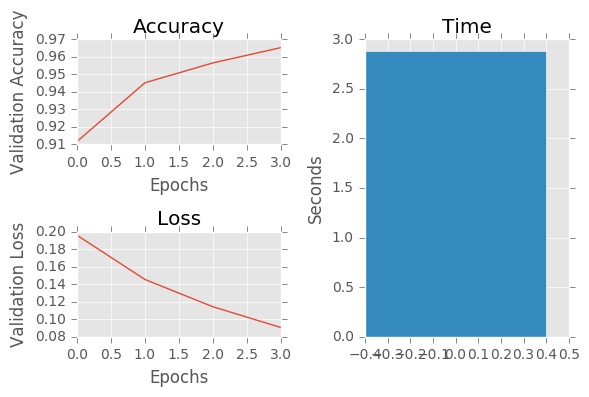

In [10]:
# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')

for result in results:
    ax1.plot(result[0].epoch, result[0].history['val_acc'])
    ax2.plot(result[0].epoch, result[0].history['val_loss'])

ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
         align='center')
plt.tight_layout()
plt.show()

('Test loss:', 0.090804476945426829)
('Test accuracy:', 0.96516230958253191)
0.98

Accuracy: 89.4808279606%
Recall: 89.4808279606%
f1_score: 89.4679232309%

Confusion Matrix:
[[477   2  17   0   0   0]
 [ 15 422  34   0   0   0]
 [ 13   2 405   0   0   0]
 [  0  24   0 399  68   0]
 [  0   2   0 106 424   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[ 16.18595123   0.06786563   0.57685781   0.           0.           0.        ]
 [  0.5089922   14.31964684   1.15371561   0.           0.           0.        ]
 [  0.44112659   0.06786563  13.74278927   0.           0.           0.        ]
 [  0.           0.8143875    0.          13.5391922    2.30743122   0.        ]
 [  0.           0.06786563   0.           3.59687805  14.38751221   0.        ]
 [  0.           0.91618598   0.           0.           0.          17.30573463]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of th

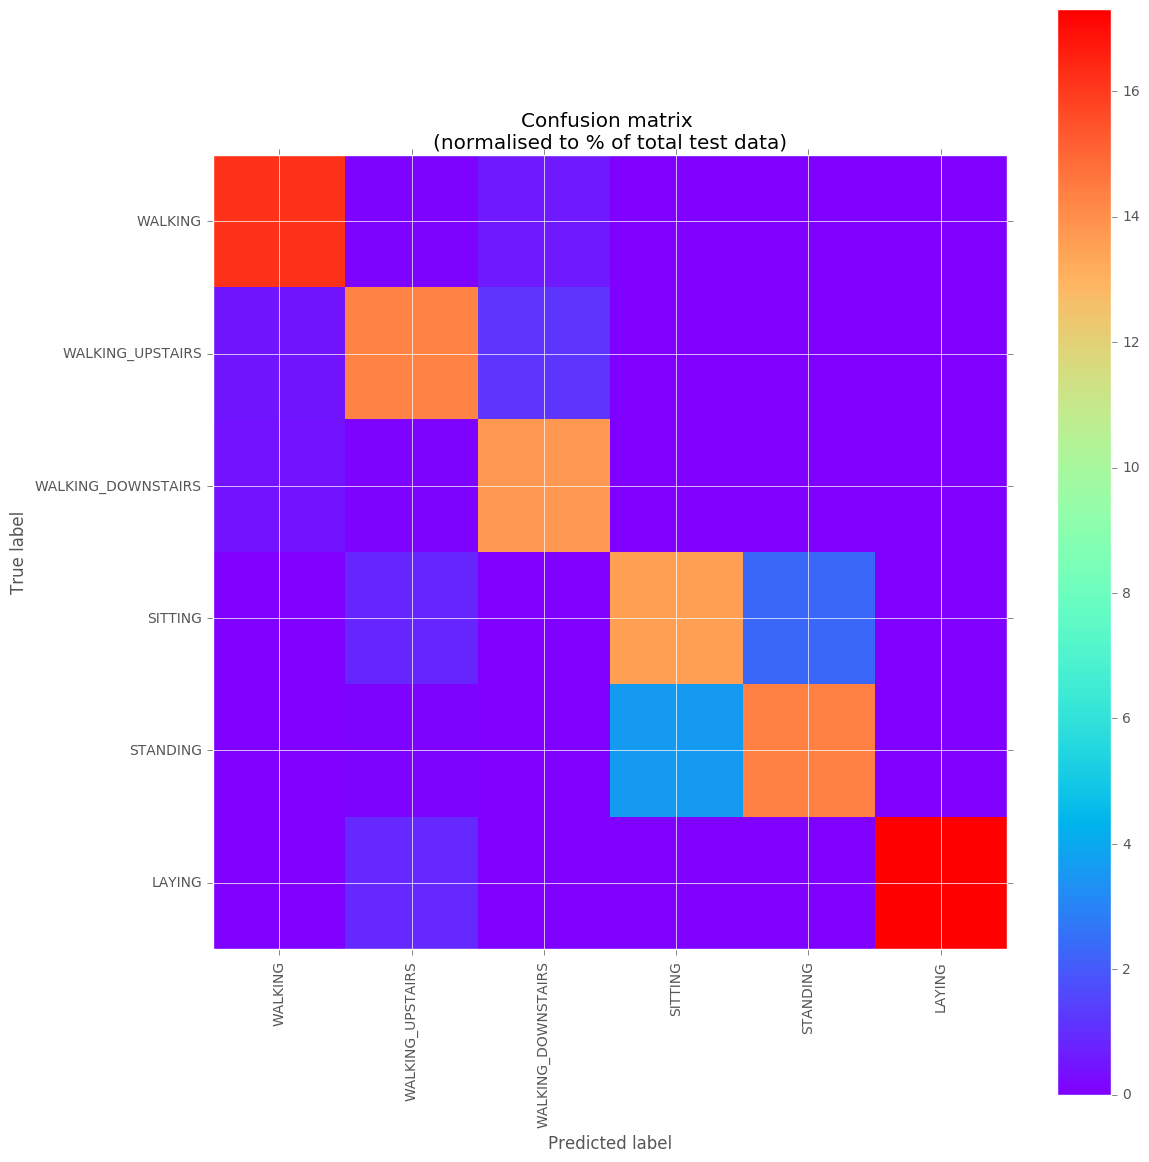

In [12]:
# Results

score = model.evaluate(X_test, one_hot(y_test), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
start = time.clock()
predictions_one_hot = model.predict(X_test)
end = time.clock()
print  (end - start)
predictions = predictions_one_hot.argmax(1)

# print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Accuracy: {}%".format(100*metrics.accuracy_score(y_test, predictions)))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
# confusion_matrix = metrics.confusion_matrix(one_hot(y_test), predictions_one_hot)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(num_output)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()